In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
size_2 = (6,4)
size_3 = (3.08, 2.31)
plt.rcParams['figure.figsize'] = size_2
plt.rcParams['font.size'] = 24
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markeredgewidth'] = 1
plt.rcParams['lines.markersize'] = 5
plt.rcParams['lines.markerfacecolor'] = 'none'
plt.rcParams['legend.framealpha'] = 1
plt.rcParams['legend.loc'] = 'best'
plt.rcParams['legend.frameon'] = False
plt.rcParams['savefig.format'] = 'pdf'
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['xtick.major.pad'] = '7.5'
plt.rcParams['ytick.major.pad'] = '7.5'
plt.rcParams['axes.formatter.use_mathtext'] = True
try:
    from matplotlib_inline.backend_inline import set_matplotlib_formats
except:
    from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

In [3]:
data = pd.read_csv('./owid-covid-data.csv')
USA_data = data[data['iso_code'] == 'USA']
UK_data = data[data['iso_code'] == 'GBR']
CHN_data = data[data['iso_code'] == 'CHN']
SGP_data = data[data['iso_code'] == 'SGP']
Popularity = np.array([3.295e9,6.708e8,1.411e10,5.68e6])

In [43]:
def seir_decay_model(y,t,alpha,beta,kappa,gamma,Lambda,eta,xi,theta,N):
    S,P,E,I,Q,R,D = y
    if t < vaccine_date:
        alpha = 0
    if t > 10 and t <=37:
        beta = 0.47
        kappa = beta/10
    elif t > 37:
        beta = 0.3
        Lambda = 0.8
        kappa = beta/20
    dSdt = -beta*I*S/N-kappa*Q*S/N-alpha*S+ theta*(R+P)
    dPdt = alpha*S - theta*P
    dEdt = beta*I*S/N+kappa*Q*S/N-gamma*E
    dIdt = gamma*E-Lambda*I-eta*I
    dQdt = Lambda*I-eta*Q-xi*Q
    dRdt = eta*(Q+I)-theta*R
    dDdt = xi*(Q+I)
    return [dSdt,dPdt,dEdt,dIdt,dQdt,dRdt,dDdt]

In [44]:
#validation
alpha = 0.005 # vaccine rate
vaccine_date = 100 # start date of vaccine 
beta = 0.2  # transmission rate of susceptible 
kappa = beta/10 # transmission rate of quanrantined individuals
gamma = 0.1 # latent rate
Lambda = 0.15 # quarantine ratio
eta = 0.1 # recovery rate
xi = 0.0001 # death rate
theta = 1/180 # recovery decay

N = Popularity[0]
start_index = 710
I = np.sum(USA_data['new_cases_smoothed'].iloc[start_index-10:start_index])
R = np.sum(USA_data['new_cases_smoothed'].iloc[0:start_index-10])
E = I
D = 0
Q = 0
P = 0
S = N-I-R-D-Q-P
initial_conditions_seir_decay = [S,P,E,I,Q,R,D]
t_length = 90
t_seir_decay = np.arange(1,t_length+1,1)
solution_seir_decay = odeint(seir_decay_model, initial_conditions_seir_decay, t_seir_decay, args=(alpha,beta,kappa,gamma,Lambda,eta,xi,theta,N))
S,P,E,I,Q,R,D = solution_seir_decay.T
New_cases_seir_decay = gamma*E

In [45]:
USA_data['date'].iloc[start_index]

'2021-12-15'

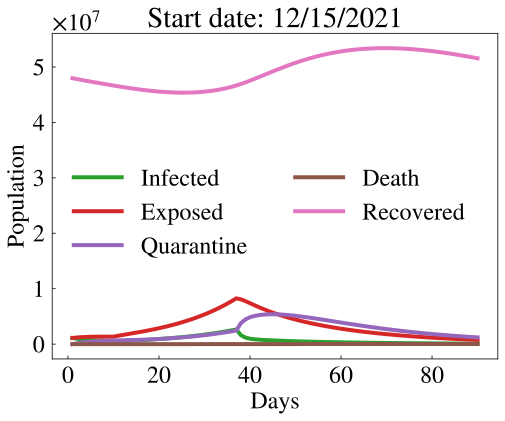

In [48]:
plt.figure(figsize=(8, 6))
linewidth = 4
# plt.plot(t_seir_decay, S, label='Susceptible', color='C0')
# plt.plot(t_seir_decay, P, label='Protected', color='C1',linewidth = linewidth)
plt.plot(t_seir_decay, I, label='Infected', color='C2',linewidth = linewidth)
plt.plot(t_seir_decay, E, label='Exposed', color='C3',linewidth = linewidth)
plt.plot(t_seir_decay, Q, label='Quarantine', color='C4',linewidth = linewidth)
plt.plot(t_seir_decay, D, label='Death', color='C5',linewidth = linewidth)

plt.plot(t_seir_decay, R, label='Recovered', color='C6',linewidth = linewidth)
plt.xlabel('Days')
plt.ylabel('Population')
plt.title('Start date: 12/15/2021')
plt.legend(ncol = 2,loc = 'upper left',bbox_to_anchor = (0,0.65))
# plt.yscale('log')
# plt.grid()
# plt.show()
# plt.savefig('Population_day_12152021.pdf')

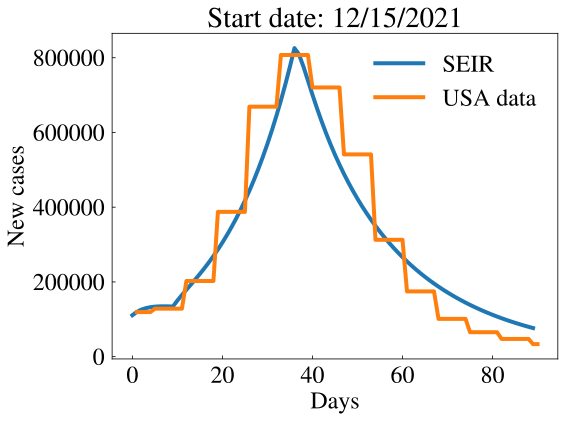

In [49]:
plt.figure(figsize=(8, 6))
plt.plot(New_cases_seir_decay,linewidth = linewidth,label = 'SEIR')
plt.plot(t_seir_decay,USA_data['new_cases_smoothed'].iloc[start_index:start_index+t_length],linewidth = linewidth,label = 'USA data')
plt.xlabel('Days')
plt.ylabel('New cases')
plt.title('Start date: 12/15/2021')
plt.legend()
# plt.savefig('New_cases_12152021.pdf')